In [52]:
import pandas as pd

df = pd.read_csv("../output/processed_data.csv")
print(df.shape)
print(df.columns)
df[["company_description", "cluster_id", "top_keywords"]].sample(3)

(911, 39)
Index(['id', 'company_description', 'source', 'is_edited', 'created_at',
       'char_count', 'word_count', 'cleaned_description', 'cleaned_doc',
       'stopword_ratio', 'unique_word_ratio', 'noun_verb_ratio',
       'sentence_count', 'avg_word_length', 'masked_url_list',
       'has_masked_url', 'masked_email_list', 'has_masked_email',
       'masked_money_list', 'has_masked_money', 'masked_date_list',
       'has_masked_date', 'masked_description', 'lemmatized_description',
       'top_keywords', 'keyword_text', 'cluster_id', 'distance_to_centroid',
       'cluster_top_keywords', 'has_org', 'has_money', 'has_date', 'has_gpe',
       'first_org', 'first_money', 'first_date', 'first_gpe', 'num_entities',
       'first_10_entities_json'],
      dtype='object')


,company_description,cluster_id,top_keywords
274,We are the market-leading manufacturer for all...,4,"['lead manufacturer', 'fastener requirement', ..."
48,Culinary Agents is a career-related website fo...,5,"['culinary agent', 'culinary', 'agent career',..."
732,Think Company uses research to design and buil...,2,"['think company', 'research design', 'use rese..."


In [53]:
from scipy import sparse

tfidf_matrix = sparse.load_npz("../output/tfidf_matrix.npz")
print(tfidf_matrix.shape)
print(tfidf_matrix.nnz)

(911, 1000)
18045


In [54]:
terms = pd.read_csv("../output/tfidf_terms.csv", header=None)[0]
print(len(terms))
terms.sample(5).tolist()


1001


['star', 'level', 'commitment', 'establish', 'thank']

In [55]:
import numpy as np

embeddings = np.load("../output/sentence_embeddings.npy")
print(embeddings.shape)
print(np.linalg.norm(embeddings[0]))

(911, 384)
1.0


In [56]:
norms = np.linalg.norm(embeddings, axis=1)
print(norms.min())
print(norms.max())
print(norms.mean())
print(norms.std())

0.9999999
1.0000001
1.0
4.353505e-08


In [57]:
assert df.shape[0] == tfidf_matrix.shape[0] == embeddings.shape[0], "Row counts do not match"

In [58]:
df.isnull().sum()[df.isnull().sum() > 0]

first_org      337
first_money    897
first_date     631
first_gpe      655
dtype: int64

As the data appears to be largely what we expected in terms of shape and format, we can explore it in more detail

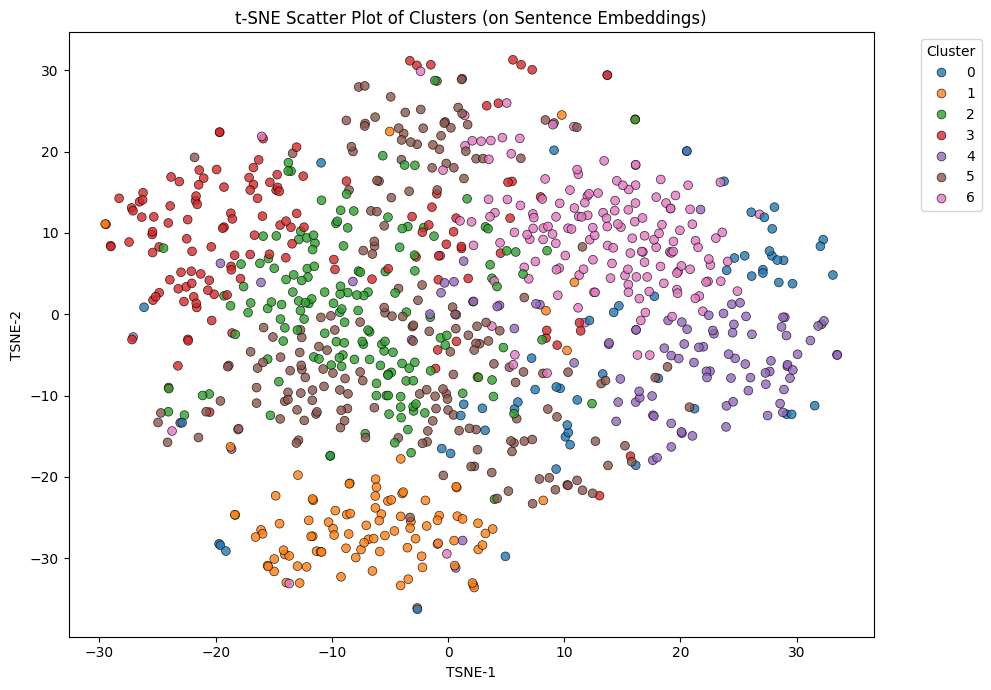

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def plot_cluster_scatter(embeddings, perplexity, cluster_ids):
    """
    Visualise clusters using t-SNE on sentence embeddings.
    """
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca")
    reduced = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=cluster_ids, palette="tab10", s=40, alpha=0.8, edgecolor="k")
    plt.title("t-SNE Scatter Plot of Clusters (on Sentence Embeddings)")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_cluster_scatter(embeddings, 30, df["cluster_id"].values)

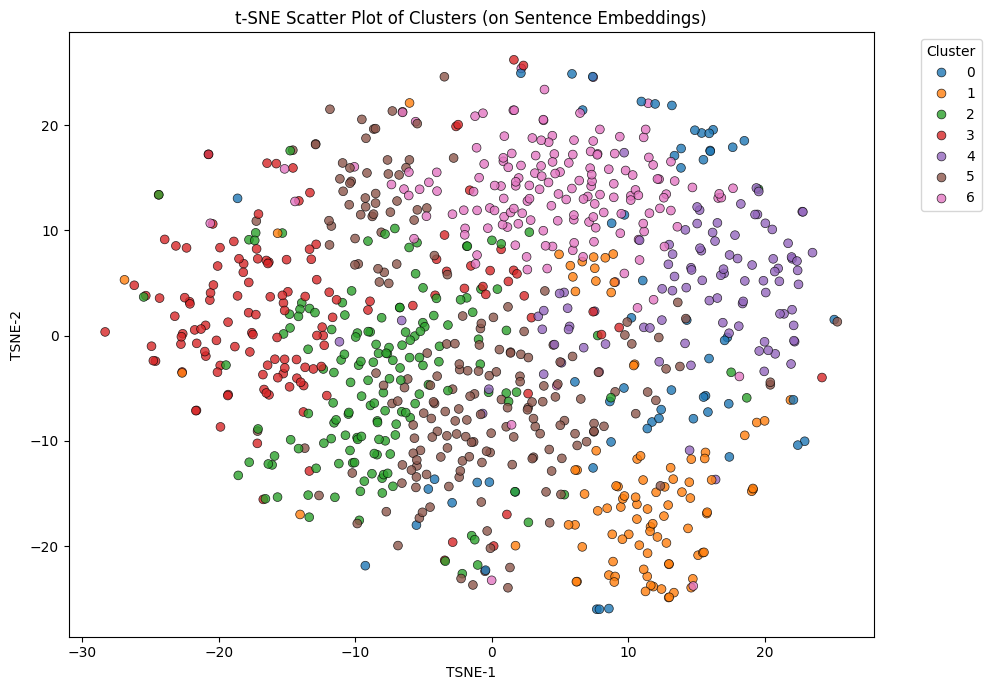

In [60]:
plot_cluster_scatter(embeddings, 40, df["cluster_id"].values)

In [ ]:
from collections import defaultdict

# Create a mapping: cluster_id to list of descriptions
cluster_texts = defaultdict(list)
for cluster_id, text in zip(df["cluster_id"], df["lemmatized_description"]):
    cluster_texts[cluster_id].append(text)

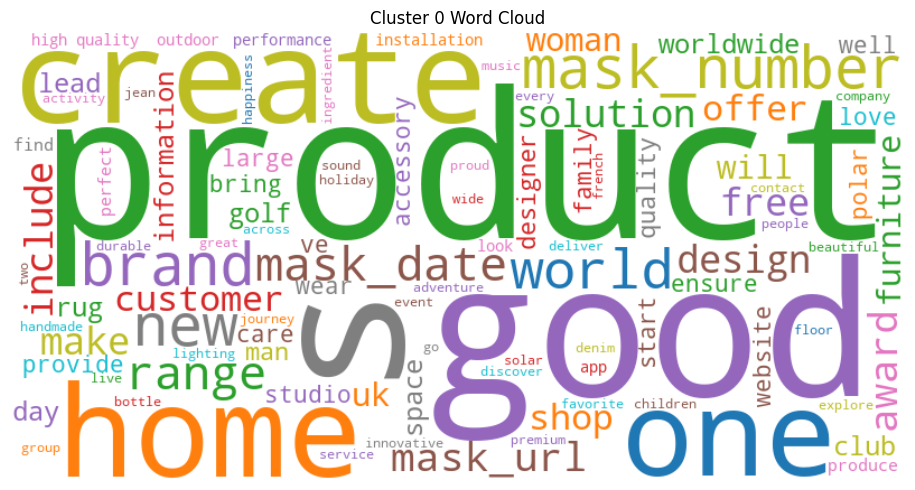

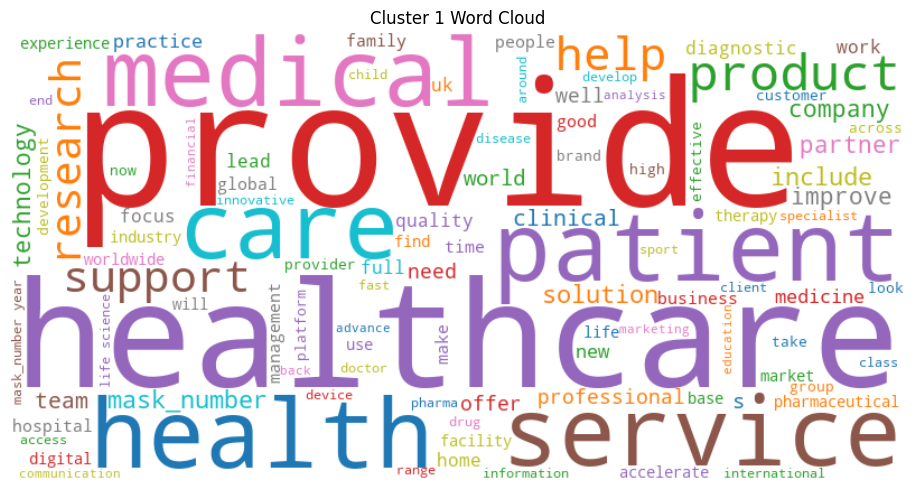

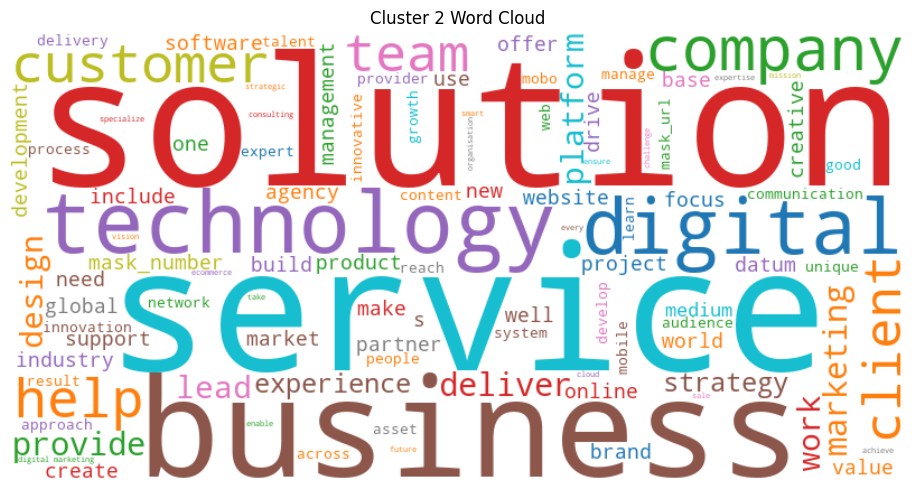

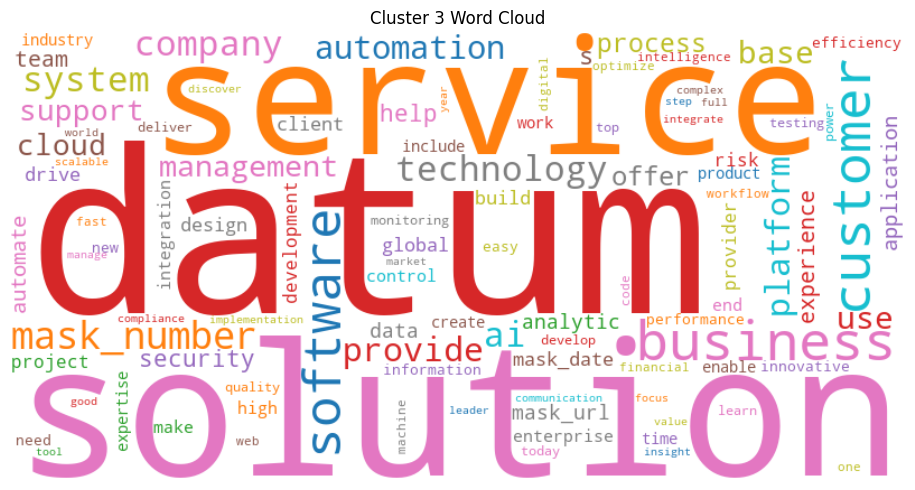

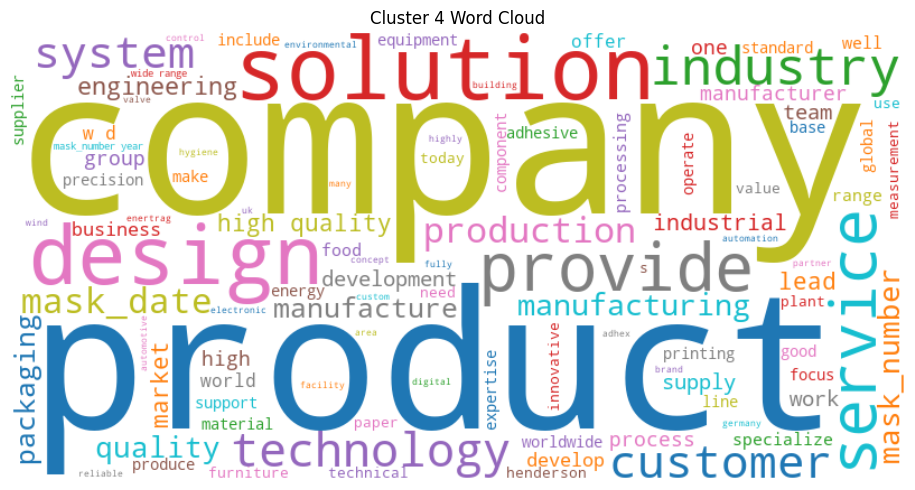

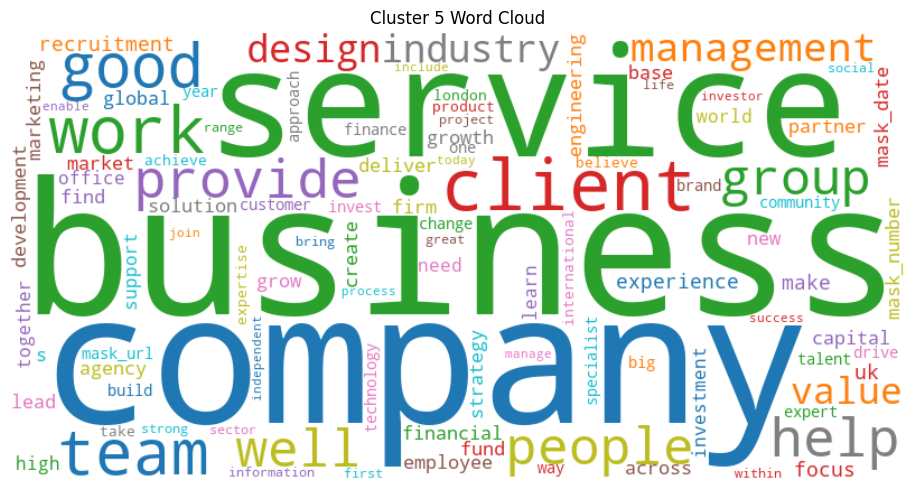

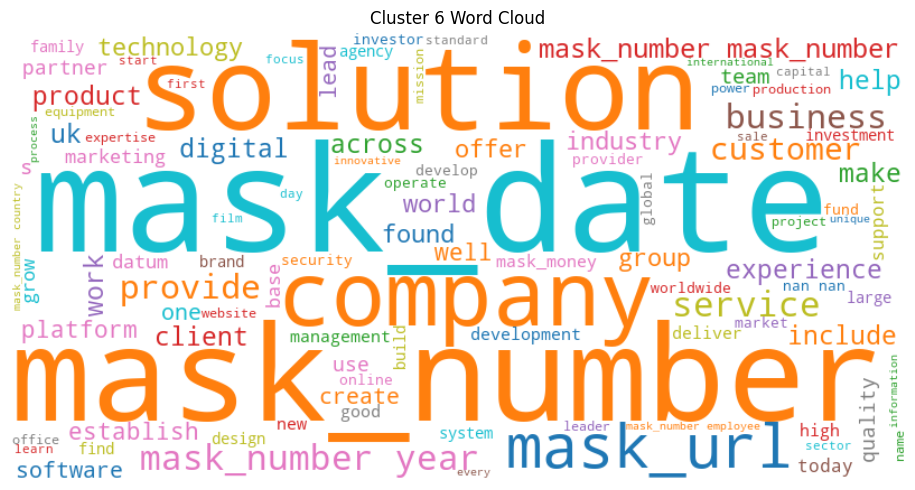

In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(cluster_texts, max_clusters=7):
    for cluster_id in sorted(cluster_texts.keys())[:max_clusters]:
        text = " ".join(cluster_texts[cluster_id])
        wordcloud = WordCloud(width=800, height=400, background_color="white",
                              max_words=100, colormap="tab10").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cluster_id} Word Cloud")
        plt.tight_layout()
        plt.show()

plot_wordclouds(cluster_texts, max_clusters=7)

Whilst words such as "company", "service" and "business" dominate the clusters/space as expected, there are some clear themes such as cluster 1 being around healthcare, clusters 2 and 5 showing keywords you'd expect in a "SaaS" business and cluster 3 implying a grouping of technology/data services, with cluster 5 seeming to reference B2B

But this is all very high-level initial perspectives, with more time you would want to dig into this more and see if they match the actual companies too

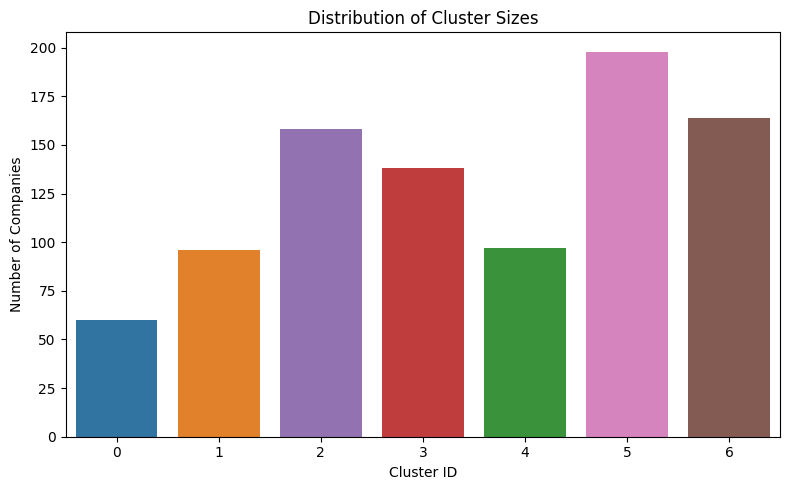

In [63]:
import seaborn as sns

def plot_cluster_sizes(df):
    cluster_counts = df["cluster_id"].value_counts().sort_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.values, palette="tab10", legend=False)
    plt.title("Distribution of Cluster Sizes")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Companies")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_cluster_sizes(df)

Not perfectly symmetrical but a decent split of companies per cluster so not an issue - no way to know if this is reasonable given real world expectations without further investigation, but seems plausible

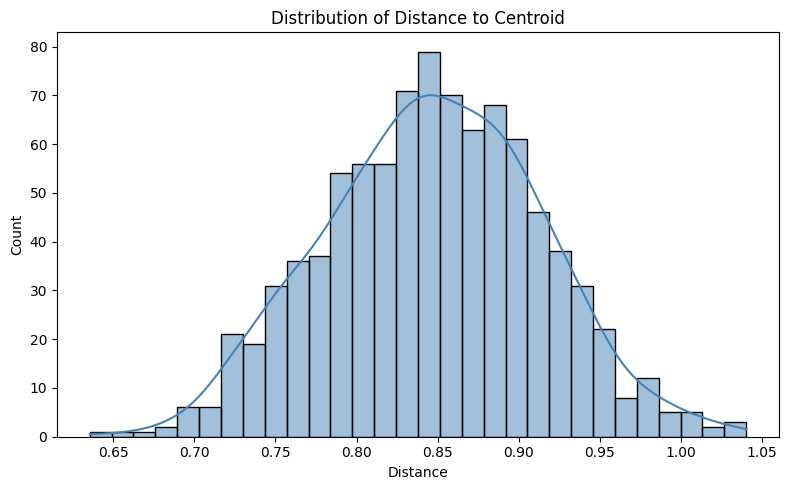

In [64]:
def plot_distance_to_centroid(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["distance_to_centroid"], bins=30, kde=True, color="steelblue")
    plt.title("Distribution of Distance to Centroid")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
plot_distance_to_centroid(df)

A very normal-shaped curve here shows that the data isn't being heavily impacted by outliers, the clusters are well-formed with a natural spread. That centered variance implies KMeans is doing a good job partitioning the semantic space

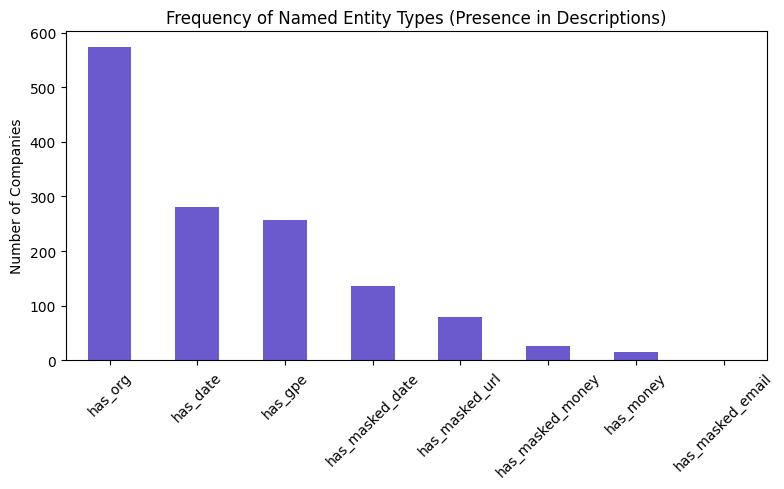

In [65]:
def plot_entity_presence(df):
    has_columns = [col for col in df.columns if col.startswith("has_")]

    counts = df[has_columns].sum().sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    counts.plot(kind="bar", color="slateblue")
    plt.title("Frequency of Named Entity Types (Presence in Descriptions)")
    plt.ylabel("Number of Companies")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_entity_presence(df)

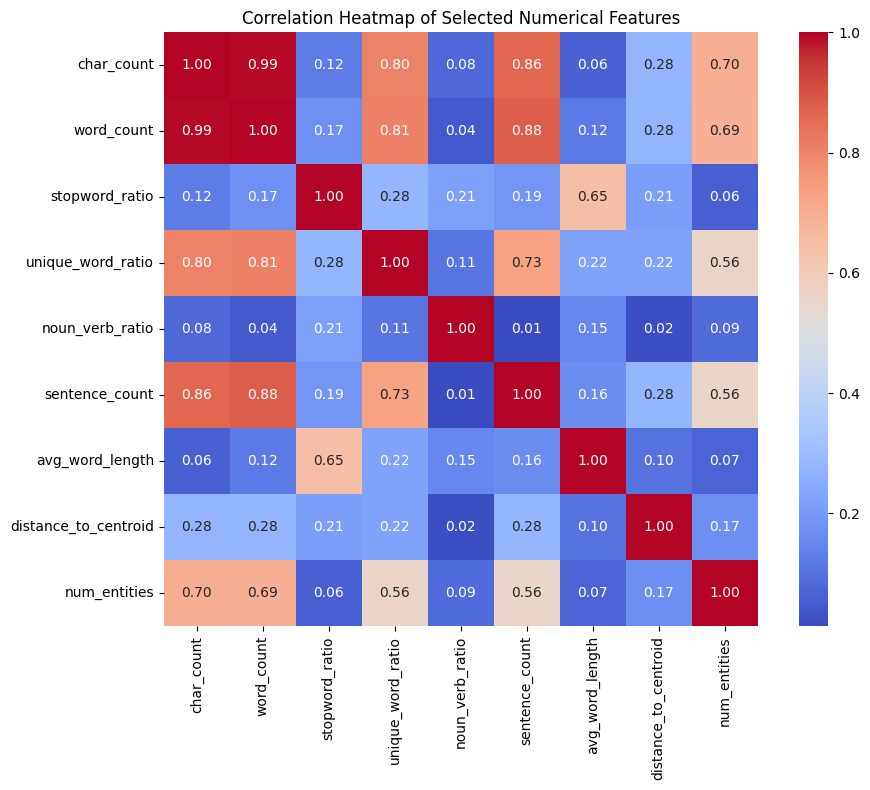

In [69]:
numerical_cols = [
    "char_count",
    "word_count",
    "stopword_ratio",
    "unique_word_ratio",
    "noun_verb_ratio",
    "sentence_count",
    "avg_word_length",
    "distance_to_centroid",
    "num_entities"
]

def plot_feature_correlation_heatmap(df, cols):
    corr = df[cols].corr().abs()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation Heatmap of Selected Numerical Features")
    plt.tight_layout()
    plt.show()

plot_feature_correlation_heatmap(df, numerical_cols)

Confirms a lot of what we'd expect, implying that a lot of these values are being created correctly. I.e. char count, word count, sentence_count, unique_word_ratio and num_entities correlating strongly. Should probably drop char or word count as they're basically holding the same information but we can leave that to model building as how you handle correlated features depends on the model/task

Also distance to centroid being so uncorrelated implies it holds useful orthogonal signal

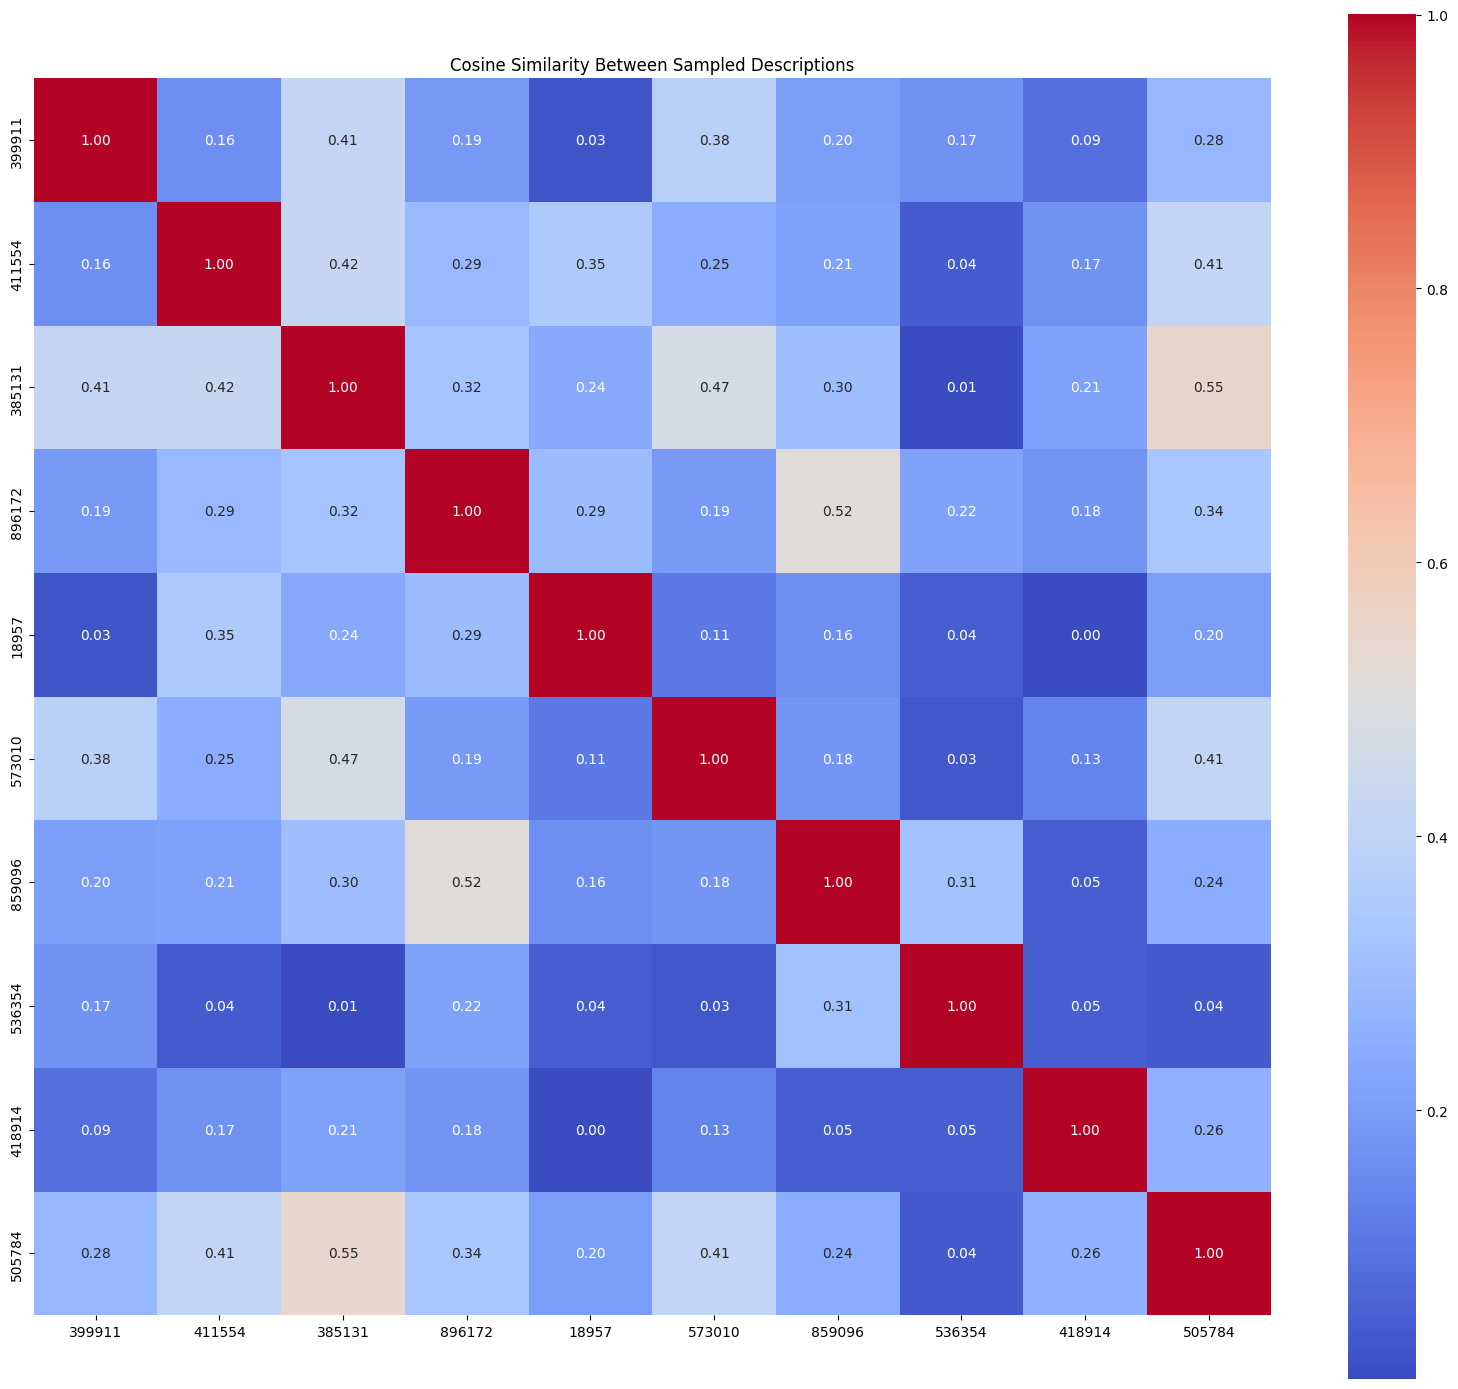

In [90]:
from sklearn.metrics.pairwise import cosine_similarity

sample_df = df.sample(10)
sample_embeddings = embeddings[sample_df.index]
sample_labels = sample_df["id"].astype(str).tolist()

similarity_matrix = cosine_similarity(sample_embeddings)

plt.figure(figsize=(16, 14))
sns.heatmap(similarity_matrix, xticklabels=sample_labels, yticklabels=sample_labels, cmap="coolwarm", annot=True, fmt=".2f", square=True)
plt.title("Cosine Similarity Between Sampled Descriptions")
plt.tight_layout()
plt.show()

In [91]:
df.loc[(df["id"] == 385131) | (df["id"] == 505784)][["cleaned_description"]].values

array([['We are CreateLondon, a multi-award-winning, event production agency. Our team produce experiential, brand activations and brand experiences for agencies and end clients, worldwide.'],
       ['Were a dedicated and passionate design agency based in the centre of England. Our humble beginnings have set us in good stead to continuously, and successfully, punch well above our weight - continually delivering a high standard across a range of disciplines from branding to large-scale web applications, retail design to targeted marketing campaigns.']],
      dtype=object)

Both seem to be correctly somewhat similar, within the creative agency space in England

In [94]:
def find_most_similar_companies(df, embeddings, top_n=3):
    # Randomly sample one company
    idx = np.random.choice(df.index)
    query_vector = embeddings[idx].reshape(1, -1)

    # Compute cosine similarity to all companies
    sims = cosine_similarity(query_vector, embeddings)[0]

    # Get top N most similar indices (excluding self)
    top_indices = sims.argsort()[::-1][1:top_n+1]

    # Display results
    print(f"\nQuery company (ID {df.loc[idx, 'id']}, cluster: {df.loc[idx, 'cluster_id']}):")
    print(df.loc[idx, "company_description"])
    print("\nMost similar companies:\n")
    
    for rank, i in enumerate(top_indices, 1):
        print(f"#{rank} (ID {df.loc[i, 'id']}, similarity: {sims[i]:.3f}, cluster: {df.loc[i, 'cluster_id']})")
        print(df.loc[i, "company_description"])
        print("-" * 80)

In [98]:
find_most_similar_companies(df, embeddings, top_n=3)


Query company (ID 833674, cluster: 0):
WE ARE SCORPIONEXO ABOUT US ScorpionEXO is, quite simply, the next wave in motorcycle helmet and protective gear design and manufacturing. ScorpionEXO

Most similar companies:

#1 (ID 392355, similarity: 0.420, cluster: 0)
By creating the world’s most portable and durable lighting gear, we desire above all else to be a source of inspiration to all adventurous spirits everywhere; helping them capture and share life’s most beautiful and greatest moments.\ What's your next adventure?\ We are the brand that brings light to their adventures.
--------------------------------------------------------------------------------
#2 (ID 554786, similarity: 0.386, cluster: 5)
We are an electric bike manufacturer Italian company with a global vision: OLI eBike Systems is your ideal partner in emtb and ebikes world!
--------------------------------------------------------------------------------
#3 (ID 901027, similarity: 0.385, cluster: 6)
Founded in 2012, EPRO 